<a href="https://colab.research.google.com/github/kbarismath/Walmart-Sales-Forecasting-ARIMA/blob/main/Walmart_Sales_Forecasting_using_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROBLEM DESCRIPTION
*One challenge of modeling retail data is the need to make decisions based on limited history. If Christmas comes but once a year, so does the chance to see how strategic decisions impacted the bottom line.

In this recruiting competition, job-seekers are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains many departments, and participants must project the sales for each department in each store. To add to the challenge, selected holiday markdown events are included in the dataset. These markdowns are known to affect sales, but it is challenging to predict which departments are affected and the extent of the impact.*

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [19]:
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv.zip')

# DATA PREPROCESSING

In [20]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [21]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


None

In [22]:
train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [23]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [24]:
train.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [25]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [26]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [27]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


***Unique Store Types***

In [28]:
display(stores['Type'].unique())

array(['A', 'B', 'C'], dtype=object)

***Unique Departments***

In [29]:
display(train['Dept'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56,
       58, 59, 60, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90,
       91, 92, 93, 94, 95, 96, 97, 98, 99, 39, 50, 43, 65])

# FEATURE ENGINEERING
***Combining Store and Department infos***

In [30]:
train['Store_Dept'] = train['Store'].astype(str) + '_' + train['Dept'].astype(str)
test['Store_Dept'] = test['Store'].astype(str) + '_' + test['Dept'].astype(str)

***Extracting month and year from 'Date' column:***

In [31]:
train['Month'] = pd.to_datetime(train['Date']).dt.month
train['Year'] = pd.to_datetime(train['Date']).dt.year

test['Month'] = pd.to_datetime(test['Date']).dt.month
test['Year'] = pd.to_datetime(test['Date']).dt.year

features['Month'] = pd.to_datetime(features['Date']).dt.month
features['Year'] = pd.to_datetime(features['Date']).dt.year

***Calculating the total amount of markdowns***

In [32]:
features['Total_MarkDown'] = features['MarkDown1'] + features['MarkDown2']+ features['MarkDown3'] + features['MarkDown4'] + features['MarkDown5']

***Encoding categorical variables***

In [33]:
store_type_dummies = pd.get_dummies(stores['Type'], prefix = 'Store_Type', drop_first=True)
stores= pd.concat([stores, store_type_dummies], axis = 1)

***Mergeing add. features to datasets***

In [34]:
train = train.merge(stores, on='Store', how = 'left')
train = train.merge(features, on= ['Store', 'Date'], how='left')
test = test.merge(stores, on='Store',how = 'left')
test= test.merge(features,on =['Store','Date'], how ='left')

In [35]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Store_Dept,Month_x,Year_x,Type,Size,...,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Month_y,Year_y,Total_MarkDown
0,1,1,2010-02-05,24924.50,False,1_1,2,2010,A,151315,...,NaN,NaN,NaN,NaN,211.096358,8.106,False,2,2010,NaN
1,1,1,2010-02-12,46039.49,True,1_1,2,2010,A,151315,...,NaN,NaN,NaN,NaN,211.242170,8.106,True,2,2010,NaN
2,1,1,2010-02-19,41595.55,False,1_1,2,2010,A,151315,...,NaN,NaN,NaN,NaN,211.289143,8.106,False,2,2010,NaN
3,1,1,2010-02-26,19403.54,False,1_1,2,2010,A,151315,...,NaN,NaN,NaN,NaN,211.319643,8.106,False,2,2010,NaN
4,1,1,2010-03-05,21827.90,False,1_1,3,2010,A,151315,...,NaN,NaN,NaN,NaN,211.350143,8.106,False,3,2010,NaN


In [36]:
test.head()

,Store,Dept,Date,IsHoliday_x,Store_Dept,Month_x,Year_x,Type,Size,Store_Type_B,...,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Month_y,Year_y,Total_MarkDown
0,1,1,2012-11-02,False,1_1,11,2012,A,151315,False,...,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,11,2012,18342.28
1,1,1,2012-11-09,False,1_1,11,2012,A,151315,False,...,3370.89,40.28,4646.79,6154.16,223.481307,6.573,False,11,2012,25633.44
2,1,1,2012-11-16,False,1_1,11,2012,A,151315,False,...,292.10,103.78,1133.15,6612.69,223.512911,6.573,False,11,2012,17838.00
3,1,1,2012-11-23,True,1_1,11,2012,A,151315,False,...,4.17,74910.32,209.91,303.32,223.561947,6.573,True,11,2012,76311.31
4,1,1,2012-11-30,False,1_1,11,2012,A,151315,False,...,NaN,3838.35,150.57,6966.34,223.610984,6.573,False,11,2012,NaN


***Creating lag features to capture the trend and seasonality in the data***

In [37]:
train['Weekly_Sales_Lag1'] = train['Weekly_Sales'].shift(1)
train['Weekly_Sales_Lag2'] = train['Weekly_Sales'].shift(2)

***Rolling mean & Rolling std dev***

In [38]:
train['Rolling_Mean'] = train['Weekly_Sales'].rolling(window=4).mean()
train['Rolling_Std'] = train['Weekly_Sales'].rolling(window=4).std()

***Creating Seasonal Features***

In [39]:
train['Date'] = pd.to_datetime(train['Date'])

train['Month']  = train['Date'].dt.month
train['Quarter']  = train['Date'].dt.quarter
train['WeekOfYear']  = train['Date'].dt.isocalendar().week

In [40]:
display(train.head())

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Store_Dept,Month_x,Year_x,Type,Size,...,Month_y,Year_y,Total_MarkDown,Weekly_Sales_Lag1,Weekly_Sales_Lag2,Rolling_Mean,Rolling_Std,Month,Quarter,WeekOfYear
0,1,1,2010-02-05,24924.50,False,1_1,2,2010,A,151315,...,2,2010,NaN,NaN,NaN,NaN,NaN,2,1,5
1,1,1,2010-02-12,46039.49,True,1_1,2,2010,A,151315,...,2,2010,NaN,24924.50,NaN,NaN,NaN,2,1,6
2,1,1,2010-02-19,41595.55,False,1_1,2,2010,A,151315,...,2,2010,NaN,46039.49,24924.50,NaN,NaN,2,1,7
3,1,1,2010-02-26,19403.54,False,1_1,2,2010,A,151315,...,2,2010,NaN,41595.55,46039.49,32990.77,12832.106391,2,1,8
4,1,1,2010-03-05,21827.90,False,1_1,3,2010,A,151315,...,3,2010,NaN,19403.54,41595.55,32216.62,13554.047185,3,1,9


# DATA TRANSFORMATION

***Converting the 'Date' column to datetime format***

In [41]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
features['Date'] = pd.to_datetime(features['Date'])

***Sorting dataset by 'Date'***

In [42]:
train = train.sort_values('Date')
test = test.sort_values('Date')
features = features.sort_values('Date')

In [43]:
#setting 'Date' as the index

train.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)
features.set_index('Date', inplace=True)

#Filling missing values
train.fillna(0,inplace=True)
test.fillna(0,inplace=True)
features.fillna(0, inplace=True)

#Reseting index
train.reset_index(inplace=True)
test.reset_index(inplace=True)
features.reset_index(inplace=True)

In [44]:
display(features.head())

,Date,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Month,Year,Total_MarkDown
0,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2,2010,0.0
1,2010-02-05,16,19.79,2.580,0.0,0.0,0.0,0.0,0.0,189.381697,7.039,False,2,2010,0.0
2,2010-02-05,31,39.05,2.572,0.0,0.0,0.0,0.0,0.0,210.752605,8.324,False,2,2010,0.0
3,2010-02-05,21,39.05,2.572,0.0,0.0,0.0,0.0,0.0,210.752605,8.324,False,2,2010,0.0
4,2010-02-05,26,9.55,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,8.488,False,2,2010,0.0


# EDA

In [45]:
print("stores.csv columns:")
display(stores.columns)
print("\n\ntrain.csv_columns:")
display(train.columns)
print("\n\nfeatures.csv_columns")
display(features.columns)

stores.csv columns:


Index(['Store', 'Type', 'Size', 'Store_Type_B', 'Store_Type_C'], dtype='object')



train.csv_columns:


Index(['Date', 'Store', 'Dept', 'Weekly_Sales', 'IsHoliday_x', 'Store_Dept',
       'Month_x', 'Year_x', 'Type', 'Size', 'Store_Type_B', 'Store_Type_C',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y',
       'Month_y', 'Year_y', 'Total_MarkDown', 'Weekly_Sales_Lag1',
       'Weekly_Sales_Lag2', 'Rolling_Mean', 'Rolling_Std', 'Month', 'Quarter',
       'WeekOfYear'],
      dtype='object')



features.csv_columns


Index(['Date', 'Store', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'Month', 'Year', 'Total_MarkDown'],
      dtype='object')

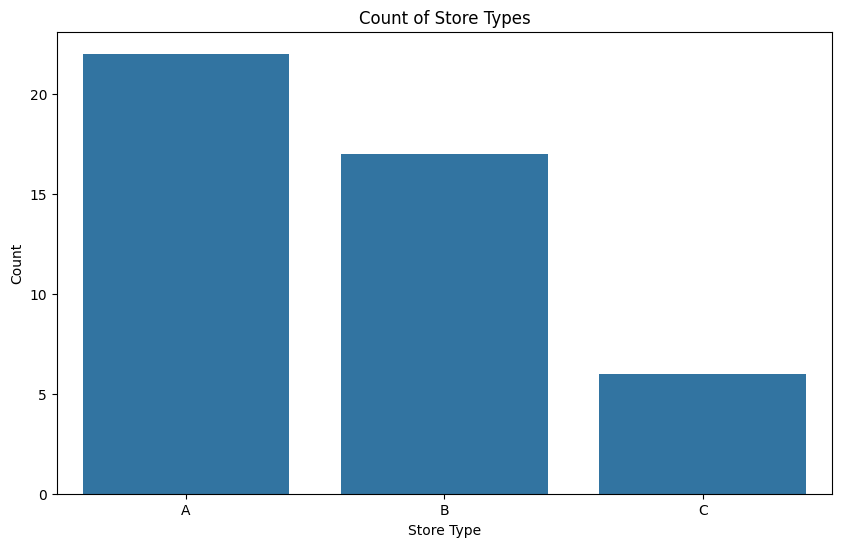

In [46]:
plt.figure(figsize=(10,6))
sns.countplot(data=stores, x='Type')
plt.title('Count of Store Types')
plt.xlabel('Store Type')
plt.ylabel('Count')
plt.show()

***Distribution of store sizes***

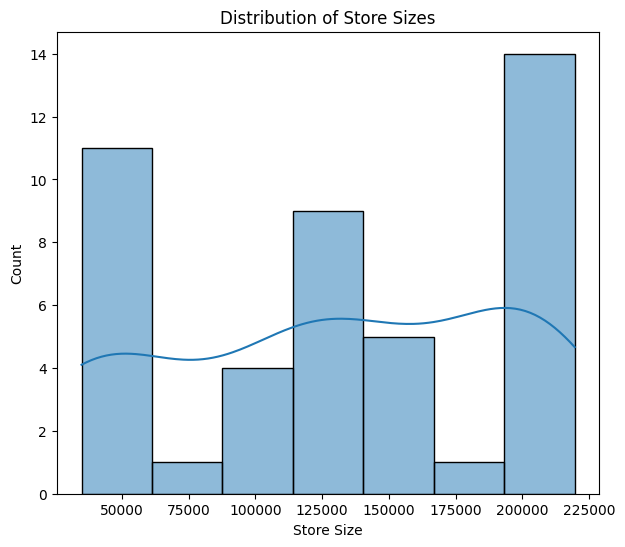

In [47]:
plt.figure(figsize=(7,6))
sns.histplot(data=stores, x='Size', kde=True)
plt.title('Distribution of Store Sizes')
plt.xlabel('Store Size')
plt.ylabel('Count')
plt.show()

***Correlation Matrix***

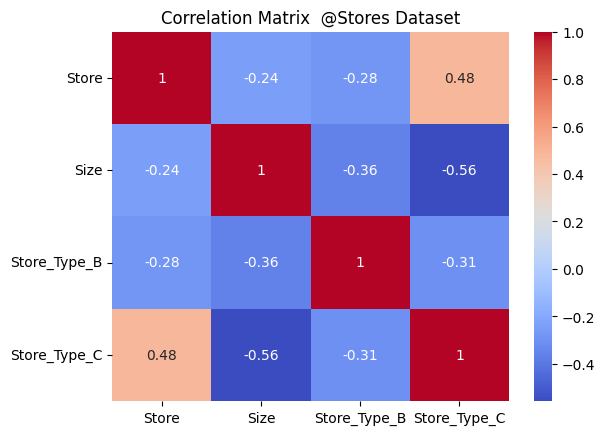

In [48]:
correlation_matrix = stores.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap= 'coolwarm')
plt.title('Correlation Matrix  @Stores Dataset')
plt.show()

***Distribution of Weekly Sales***

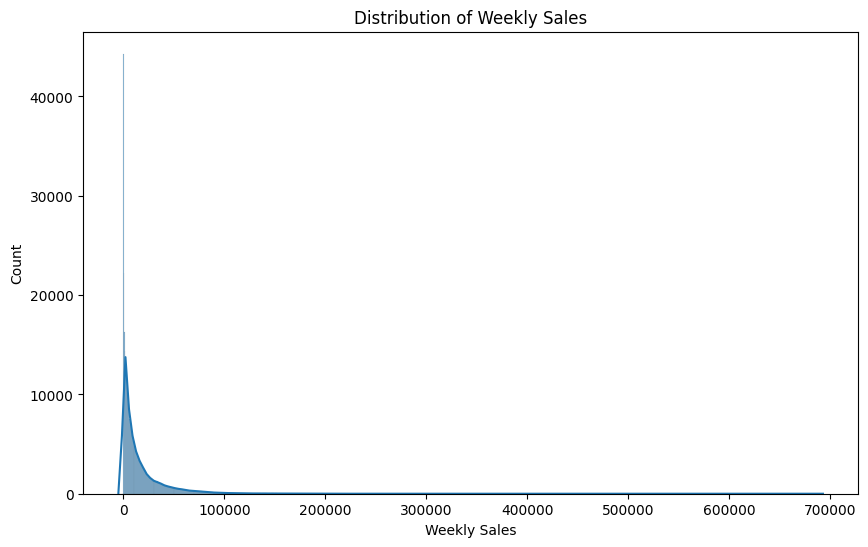

In [49]:
plt.figure(figsize=(10,6))
sns.histplot(data=train, x= 'Weekly_Sales', kde=True)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Count')
plt.show()

***Weekly Sales vs Store***

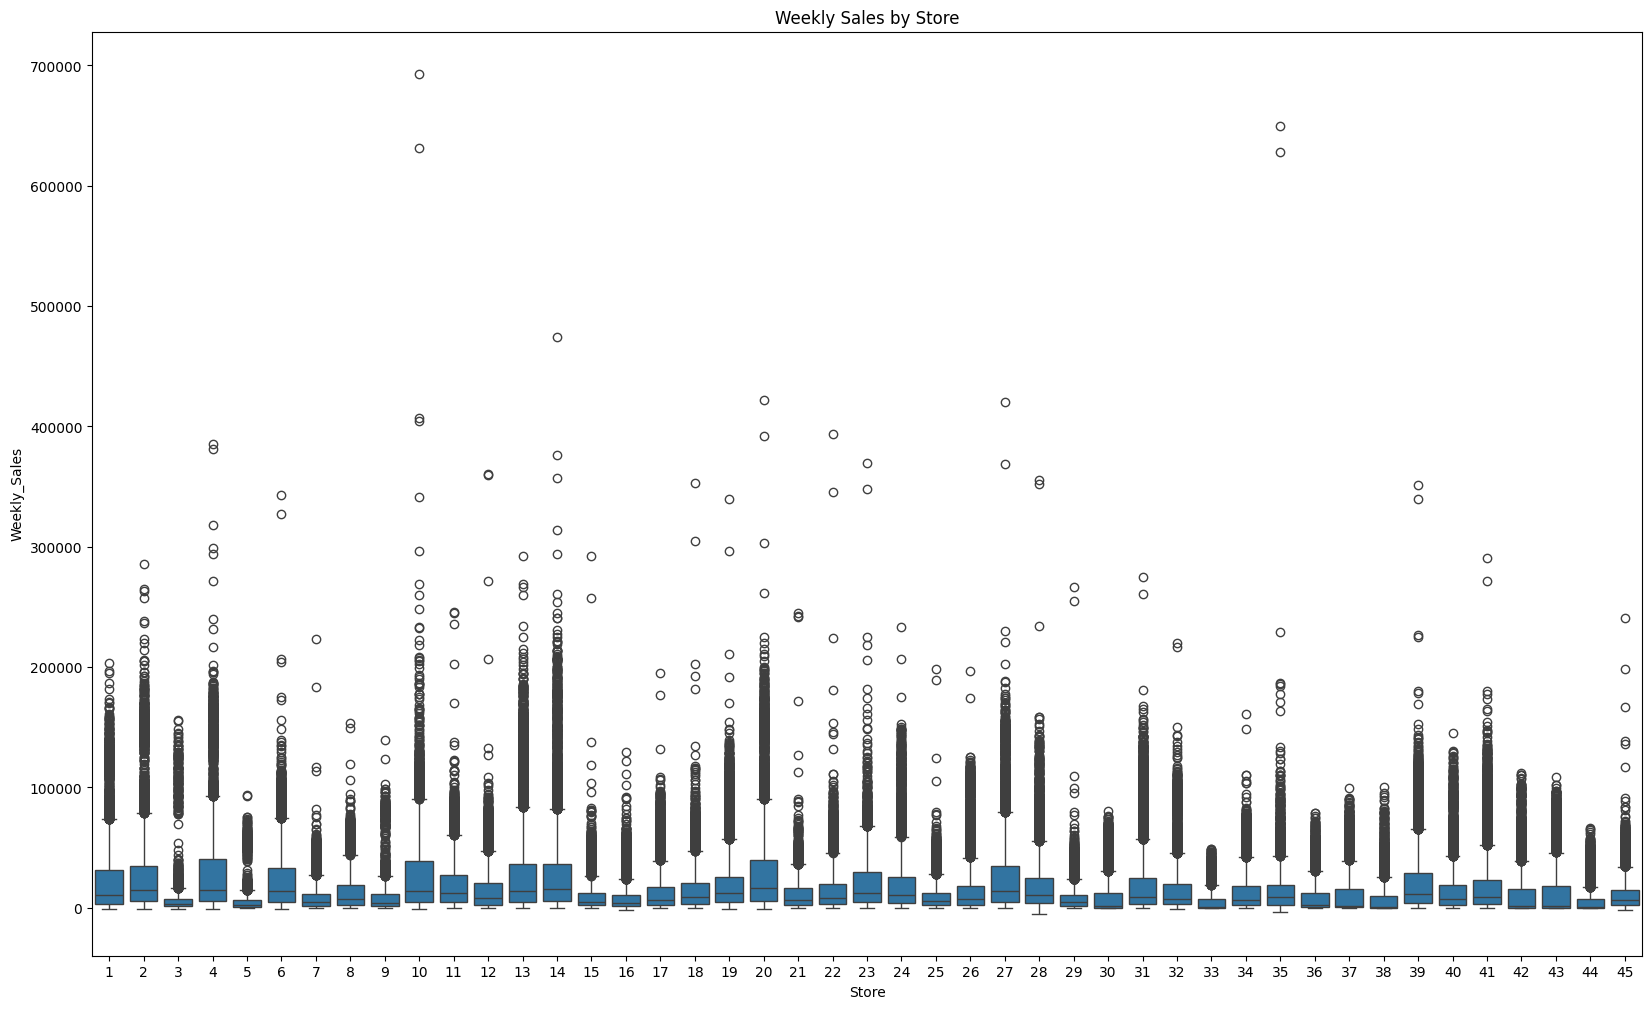

In [50]:
plt.figure(figsize=(20,12))
sns.boxplot(data=train, x='Store', y= 'Weekly_Sales')
plt.title('Weekly Sales by Store')
plt.xlabel('Store')
plt.ylabel('Weekly_Sales')
plt.show()

***Weekly sales vs department***

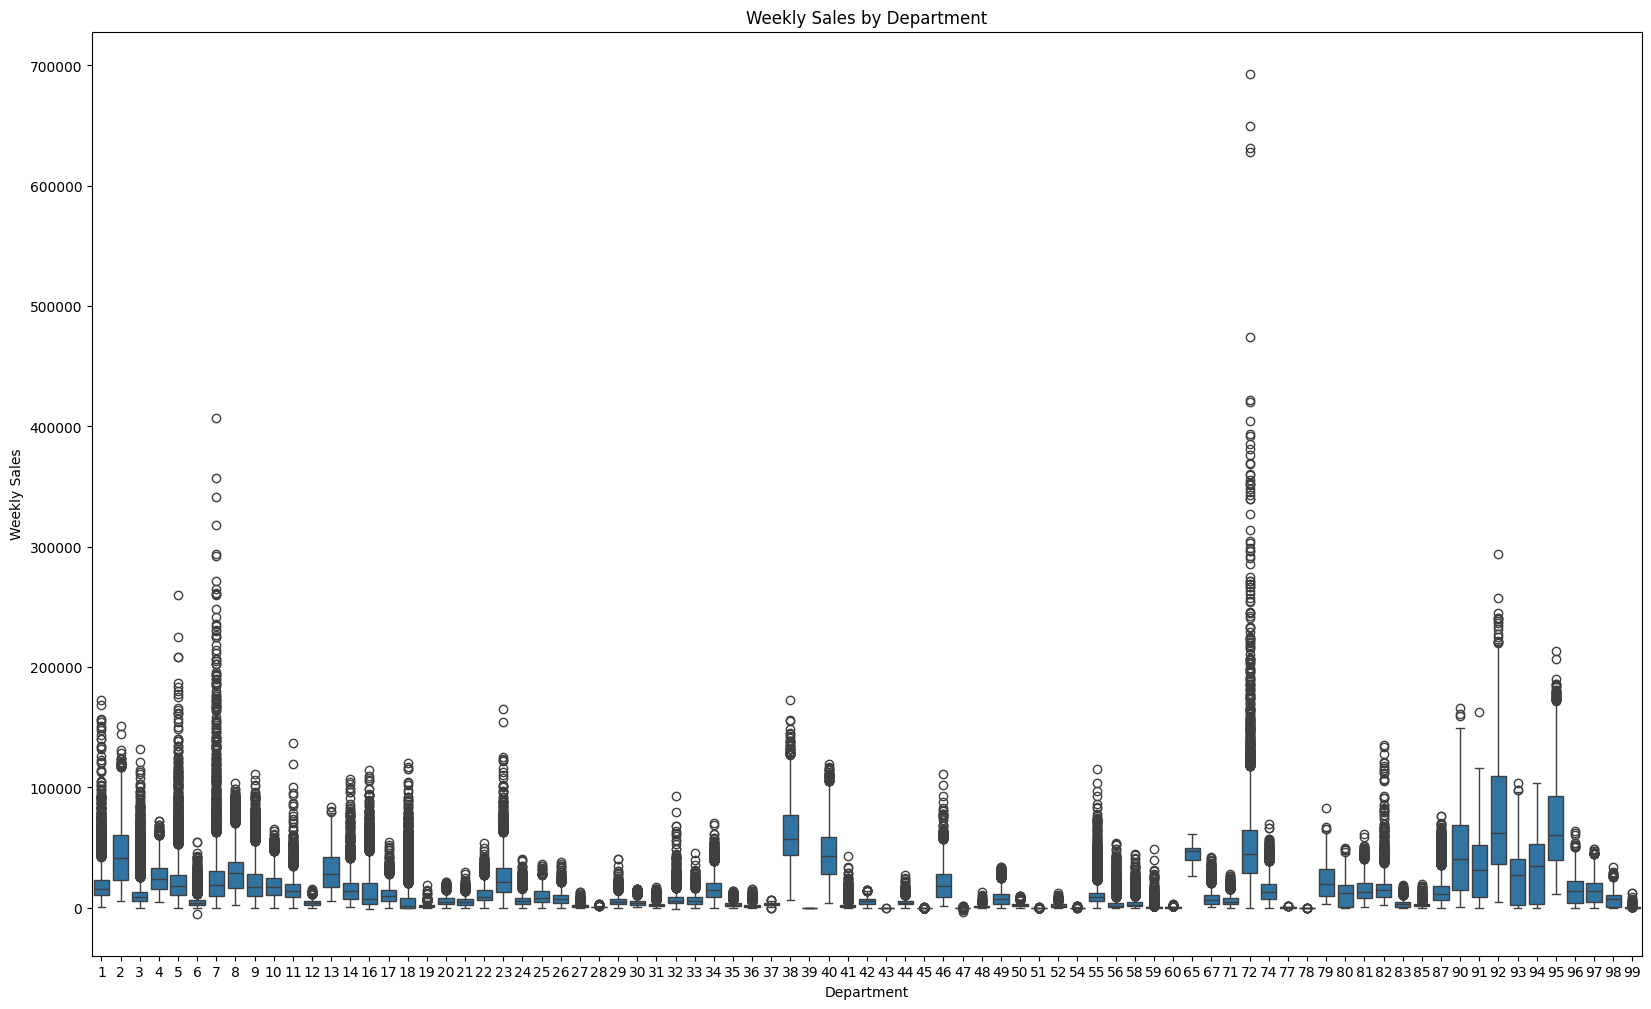

In [51]:
plt.figure(figsize=(20,12))
sns.boxplot(data = train, x='Dept', y='Weekly_Sales')
plt.title('Weekly Sales by Department')
plt.xlabel('Department')
plt.ylabel('Weekly Sales')
plt.show()

***Weekly Sales vs Over Time***

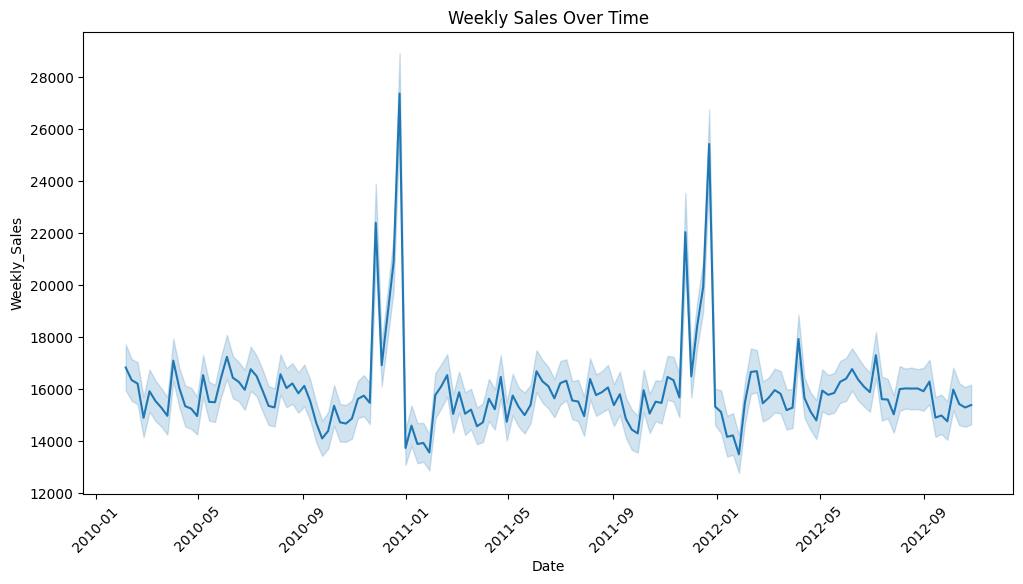

In [52]:
plt.figure(figsize=(12,6))
sns.lineplot(data = train, x='Date', y='Weekly_Sales')
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly_Sales')
plt.xticks(rotation=45)
plt.show()

***Weekly Sales vs Temperature***

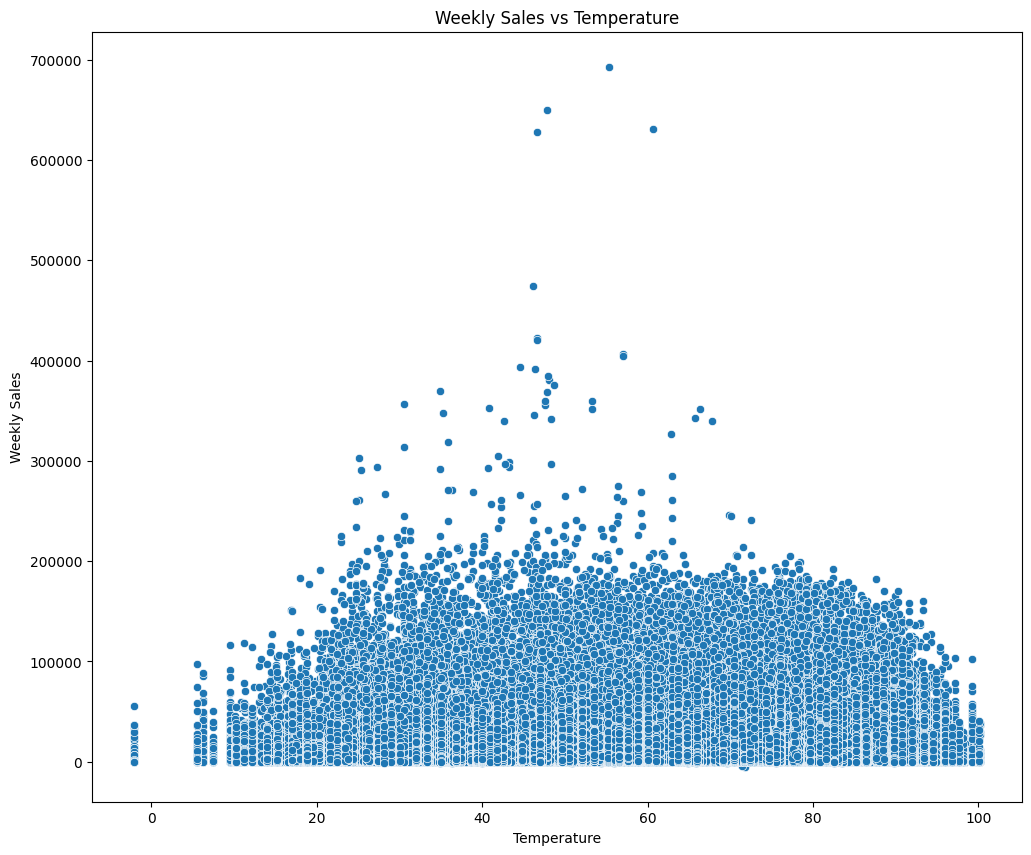

In [53]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=train, x='Temperature', y='Weekly_Sales')
plt.title('Weekly Sales vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.show()

In [54]:
cor_mx= train.corr(numeric_only=True)

fig = go.Figure(data = go.Heatmap(z = cor_mx.values, x=cor_mx.columns, y=cor_mx.columns, colorscale='Viridis'))

fig.update_layout(title = 'Correlation matrix @train dataset', xaxis_title= 'Features', yaxis_title = 'Features')
fig.update_layout(height=1000,width=1000)

pio.show(fig)

***Numerical Columns***

In [55]:
num_cols =  ['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']

***Relationships between features***

In [56]:
import warnings
warnings.filterwarnings("ignore")

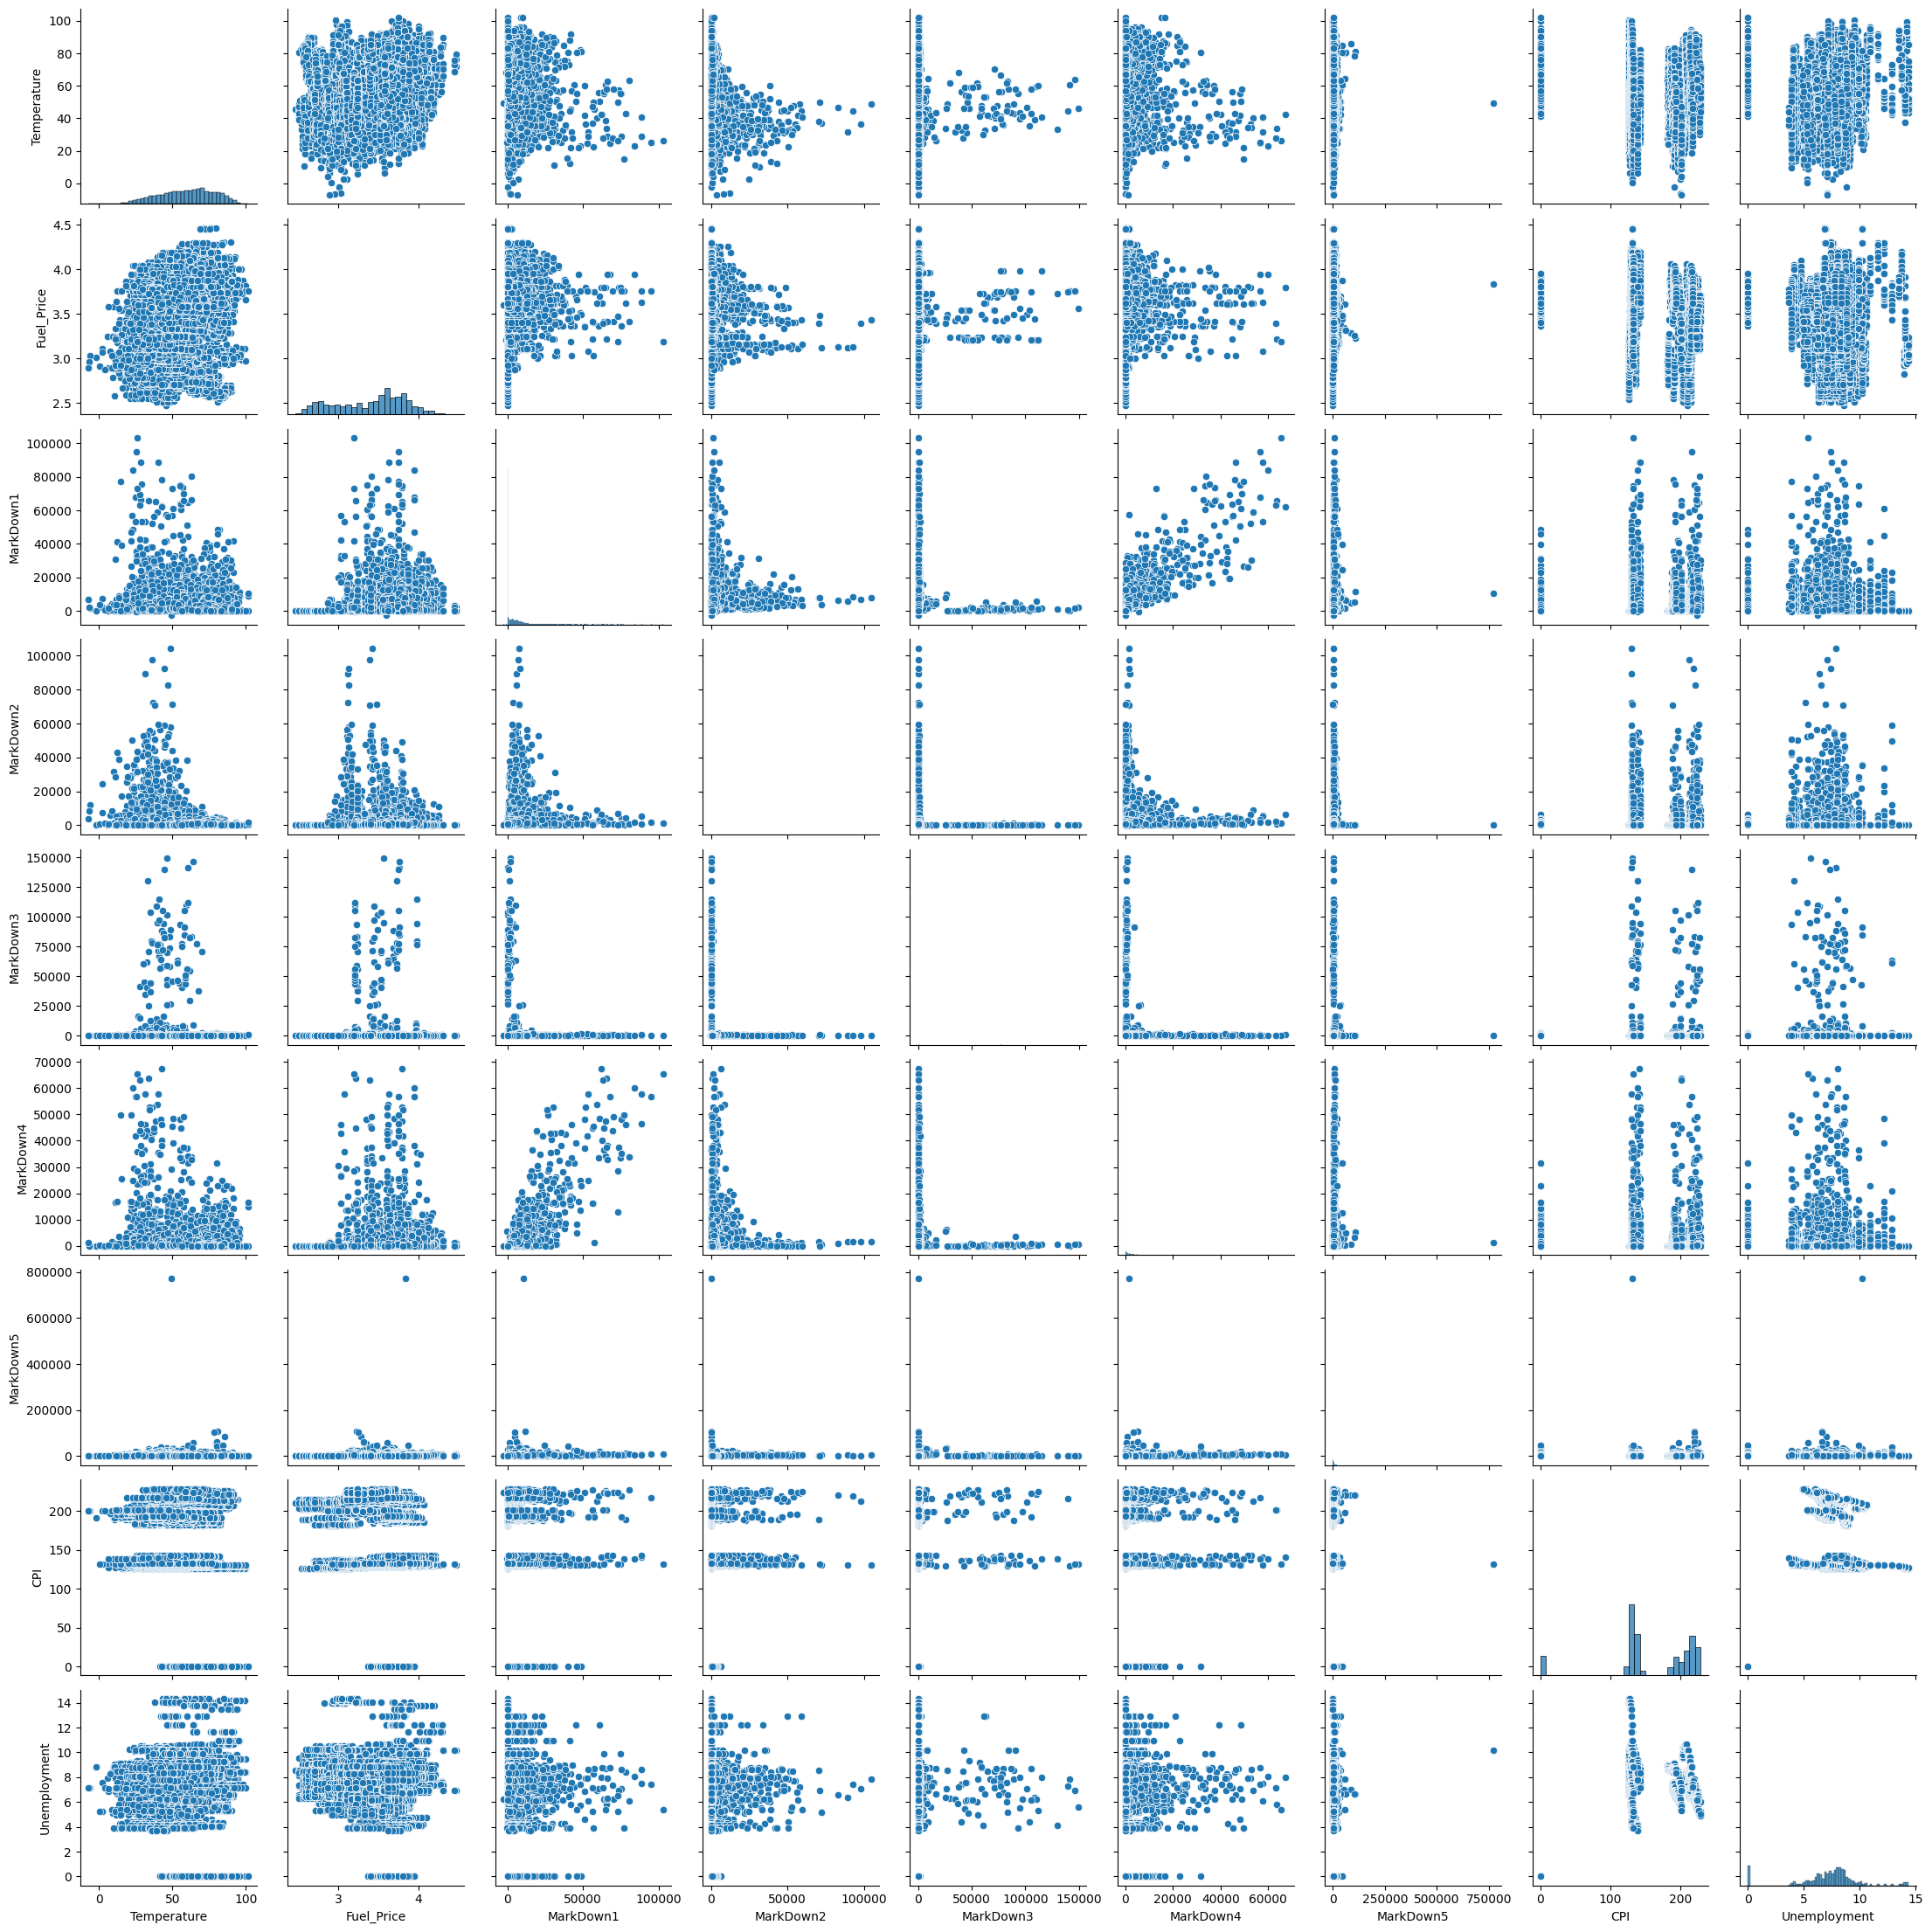

In [57]:
sns.pairplot(features[num_cols])
plt.show()

# SALES FORECASTING ( TIME SERIES ANALYSIS )

Time series analysis model is fitted to historical data to forecast future sales.

In [58]:
store= 1
department= 1

sales_data = train[(train['Store']==store) & (train['Dept']==department)]['Weekly_Sales']

#fitting the model
model = ARIMA(sales_data, order= (1, 1, 1))
model_fit= model.fit()

***Forecasting future sales:***

In [59]:
forecast_steps = 12
forecast = model_fit.forecast(steps = forecast_steps)

print(f"Forecasted sales for store {store} and department {department}: ")
display(forecast)

Forecasted sales for store 1 and department 1: 


143    25185.325151
144    23917.437422
145    23188.554930
146    22769.535427
147    22528.649761
148    22390.169562
149    22310.560154
150    22264.794348
151    22238.484530
152    22223.359559
153    22214.664525
154    22209.665930
Name: predicted_mean, dtype: float64

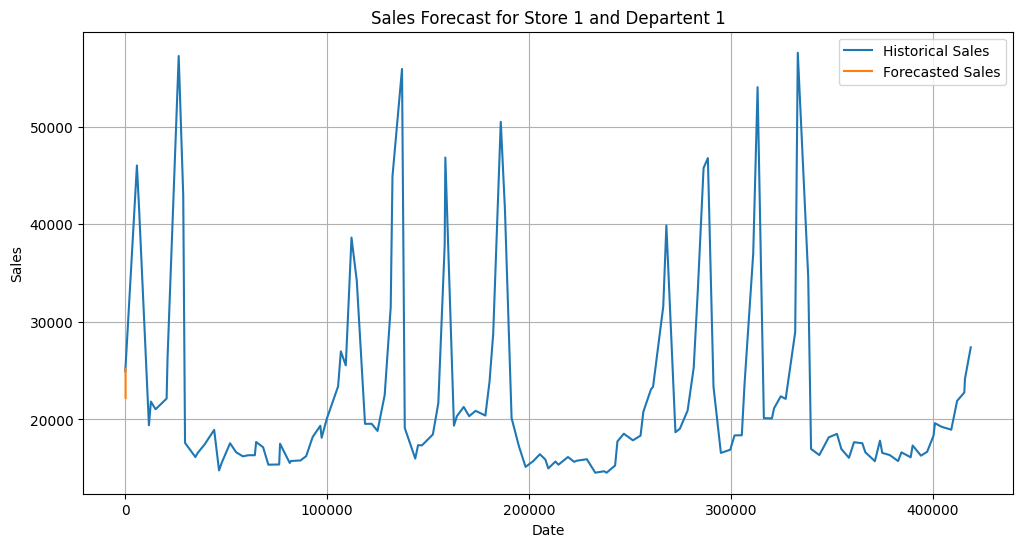

In [60]:
plt.figure(figsize=(12,6))
plt.plot(sales_data.index, sales_data.values, label ='Historical Sales')
plt.plot(forecast.index, forecast, label = 'Forecasted Sales')
plt.title(f"Sales Forecast for Store {store} and Departent {department}")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

#KEY FACTORS THAT INFLUENCES SALES

In [61]:
store = 1
department = 1
sales_data= train[(train['Store'] == store) & (train['Dept']==department)][['Date','Weekly_Sales']]
sales_data.set_index('Date', inplace=True)

result = seasonal_decompose(sales_data['Weekly_Sales'], model='additive')

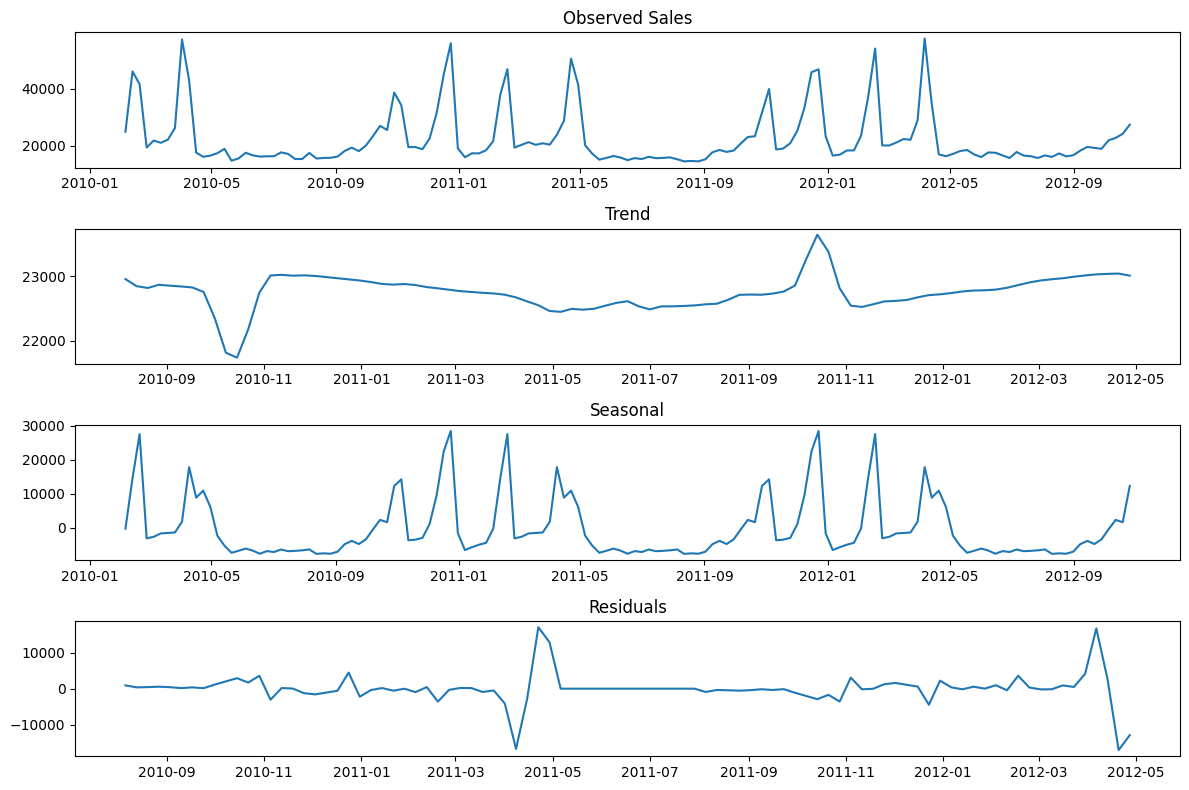

In [62]:
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(result.observed)
plt.title('Observed Sales')
plt.subplot(4,1,2)
plt.plot(result.trend)
plt.title('Trend')
plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.title('Seasonal')
plt.subplot(4,1,4)
plt.plot(result.resid)
plt.title('Residuals')
plt.tight_layout()
plt.show()